In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### We want to build a machine learning model that looks at various intersections in Toronto and predicts the collision rates expected from cyclists at each point. Using the accident history from 1986-2010, along with information such as the intersection's Bike traffic, control type, and classification (local, major arterial etc.) we should be able to use a supervised learning approach, training our algorithm on a subset of the collisions available, and the validating on other subsets. Once we are satisfied with the performance (and at some point we'll need to define where our cut-off for prediction should be), we will compare the output by applying it to accident data scrapped from a twitterbot. 

Note that we do not include whether or not an intersection has a bike lane in our list of features. While one can download a dataset which includes all locations of cycle tracks and bike lanes by street sections, many are fairly new. With the exception of certain cycle tracks which were built after 2014, there doesn't seem to be any easy way to date various bike lane additions. As such it wouldn't make sense to label our intersections with this information, as most bike lanes and cycle tracks are fairly new, and were not around during the period of time our dataset is built from. 

#### Since we don't have access to cycle app or bikeshare data to get accurate bike counts for a variety of locations, we'll need to make due with a limited dataset of city manual and automatic bike counts. These span only a few points in Toronto, and more importantly, are focused on Downtown. 

![alt text](traffic_map.png "Traffic map")

From the bike counts above, we compared to vehicle and pedestrian counts from a sepearate data set. These are far more wide ranging, and if a relationship could be found, one could make predictions on bike traffic in all the missing points.

![alt text](traffic_fit.png "Traffic fit")

While there was unfortunately no obvious direct relationship between traffic numbers (something like a constant ratio, or a linearly increasing one), we do get an acceptable power fit when comparing the bike-to-pedestrian traffic ratio, once we filter out a few areas. The University of Toronto campus has a much higher B/P ratio than any other avaialble bike count locations. This isn't suprising, as a student there I can confirm it's the most popular place to see cyclists in the city. The other area is the waterfront right by financial and entertainment districts. These points had a far lower traffic ratio than given by this fit. So we'll treat them as seperate special cases, mapping the available bike counts directly to any nearby collisions, as long as they fit within a 'box' that we'll use to define those areas.

##### Note, done in openoffice spreadsheet. Should transfer over into Python for a prettier graph. Will perhaps change the fit equation a bit 

Next we needed to clean and filter our dataset. Cleaning mostly invovled searching for NaNs or mixed up entries, as it prevents us from easily manipulating our dataframe. Once we have things roughly cleaned up, we want to filter our collisions. The bike count to pedestrian count relationship we had was based on points that were overwhelminghly found in central Toronto; downtown and the surrounding neighborhoods. So we need some way to do this

In [4]:
col_df = pd.DataFrame.from_csv('collisions_clean.csv', index_col='ID')
col_df=col_df.sort_index()
col_df.head()

,INJURY,SAFETY EQUIP.,ROAD CLASS,CYCLIST CRASH TYPE,AGE OF CYCLIST,STNAME1,STET 1 TYPE,STNAME 2,STET 2 TYPE,LONG,...,ACC TIME,ACC TIME2,TRAFFIC CONTROL,ROAD SURFACE2,DATE,DATE2,DRIVER ACTION,DRIVER CONDITION,YEAR,INTERSECTION
ID,,,,,,,,,,,,,,,,,,,,,
1,Minimal,Unrecorded,Minor Arterial,Unrecorded,34.0,BIRCHMOUNT,RD,HIGHVIEW,AV,-79.26539,...,1000.0,10:00:00,stop sign,wet,1986/01/12,1986/01/12,Failed to yield right-of-way,Normal,1986,"Birchmount Rd & Highview Ave, Toronto, Ontario..."
2,Minimal,Unrecorded,Major Arterial,Unrecorded,54.0,LAKE SHORE,BLVD,THIRTY-FIFTH,ST,-79.53500,...,1000.0,10:00:00,no control,wet,1986/01/19,1986/01/19,Improper turn,Normal,1986,"Lake Shore Blvd W & 35th St, Toronto, Ontario,..."
3,Minor,Unrecorded,Major Arterial,Unrecorded,19.0,LAWRENCE,AV,FORTUNE,GATE,-79.21800,...,1500.0,15:00:00,no control,dry,1986/01/23,1986/01/23,Failed to yield right-of-way,Normal,1986,"Lawrence Ave E & Fortune Gate, Toronto, Ontari..."
4,Minimal,Unrecorded,Local,Unrecorded,34.0,EUCLID,AV,ULSTER,ST,-79.41330,...,800.0,08:00:00,no control,loose snow,1986/01/14,1986/01/14,Lost control,Normal,1986,"Euclid Ave & Harbord St, Toronto, Ontario, M6G"
5,Minimal,Unrecorded,Major Arterial,Unrecorded,34.0,AVENUE,AV,DRAYTON,AV,-79.32041,...,1700.0,17:00:00,traffic signal,dry,1986/01/30,1986/01/30,Other,Normal,1986,"Danforth Ave & Drayton Ave, Toronto, Ontario, M4C"


The above collisions were all geocoded based on the crosstreets listed, rather than the GPS coordinates, since there were many coordinates that just were defaulted to the center of Toronto. Nonetheless, there were still a few "impossible" intersections, that were then geocded in a second pass using their coordinates. 

We also use a list of ALL the intersections in the city, and geocode those, using the GPS coordinates. These also required a second pass using a different geocoder on about 10 or so entries. Later we'll cross reference with the collisions database and drop all the duplicates. This way we can keep track of the "zeroes". That is, intersections which never had a collision in those 25 years.

Below is an example of how this was done, for the entire list of intersections in the city. We don't recommened running this, as it'll take a few hours. 

### Skip cell below!

In [ ]:
#our datasetfrom the Toronto website of all intersections
all_real_df = pd.DataFrame.from_csv('all_intersections_real.csv', index_col='int_id') 
#Get the coordinates out, put them as a list, rather than iterating over the dataframe itself.
coords2 = all_real_df[['latitude','longitude']]
coords2 = coords2.replace(np.nan,0)
coordinate_list = coords2.values.tolist() 
import geocoder
import csv
geo = []
idx = 0
for pair in coordinate_list:
    g = geocoder.arcgis(pair, method='reverse')
    geo.append(g.address)
    print(idx, '', geo[idx])
    idx += 1

myfile = open('centerline_coords_int.csv', 'w')
wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
wr.writerow(geo)

all_real_df['arcgis_int'] = geo
all_real_df.to_csv('centreline_reversegeocoded.csv')

In [13]:
import geocoder
#Example of what geocoder output looks like, for two different locations. The API calls return information on the locality in json format
latlng = [43.6532,-79.3828]
g = geocoder.arcgis('Bay St & Bloor St, Toronto', method='geocode')
f= geocoder.arcgis(latlng, method='reverse')
print(g.address)
print(f.address)

Bay St & Bloor St W, Toronto, Ontario, M5R
Bay St & Albert St, Toronto, Ontario, M5G


Once this is done, we then add this "intersection" column to our dataframe, and selected all collisions that had a postal code beginning with one of those associated with the areas roughly east of the Junction, West of carlaw, and south of Dupont, with the neigbourhoods near Exhibition place also thrown out. This isn't a perfect system by any means, but we have no reason to believe that our nice power-fit relationship will hold outside the areas we used. In fact, outside central Toronto, it seems likely that it wouldn't hold, as most cyclists are typically found closer to the city center.  

The SQl query to do this is:

#### SELECT *
#### FROM kit_farfan.centreline_reversegeocoded
#### WHERE "arcgis_int" LIKE  '%M7A%' OR "arcgis_int" LIKE '%M6G%' OR "arcgis_int" LIKE '%M6H%' OR
#### "arcgis_int" LIKE '%M6P%' OR
#### "arcgis_int" LIKE '%M5A%' OR "arcgis_int" LIKE '%M5B%' OR "arcgis_int" LIKE '%M5C%' OR
#### "arcgis_int" LIKE '%M5E%' OR "arcgis_int" LIKE '%M5G%' OR "arcgis_int" LIKE '%M5H%' OR
#### "arcgis_int" LIKE '%M5J%' OR "arcgis_int" LIKE '%M5K%' OR "arcgis_int" LIKE '%M5L%' OR
#### "arcgis_int" LIKE '%M5S%' OR "arcgis_int" LIKE '%M5T%' OR
#### "arcgis_int" LIKE '%M5V%' OR "arcgis_int" LIKE '%M5W%' OR "arcgis_int" LIKE '%M5X%' OR
#### "arcgis_int" LIKE '%M4Y%' OR "arcgis_int" LIKE '%M4X%' OR "arcgis_int" LIKE '%M4W%' OR
#### "arcgis_int" LIKE '%M4X%' OR "arcgis_int" LIKE '%M4W%'

Did it in SQL originally since exploratory data analysis was done using Mode Analytic's platform. 

In [14]:
central_realintersections_df = pd.DataFrame.from_csv('central_real_intersections.csv')
central_realintersections_df= central_realintersections_df.rename(columns = {'arcgis_int':'intersection'}) 

col_df = pd.DataFrame.from_csv('toronto_cycling_central_mode.csv', index_col='id')
col_df = col_df.sort_index()

central_col_df = col_df
from numpy import random
from scipy.spatial import distance
import matplotlib.path as mplPath
import numpy as np

#We want to follow a standard intersection convention to make our life easier. 
#Unfortunately the free geocoder with unlimited request numbers per day doesn't see mto follow one of it's own. 
#So we will get the intersections, strip out the two streets, and order them alphabetically.
st2 = col_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post = col_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 = col_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)

col_df['intersection'] = intersection_list
    
st2 = central_realintersections_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post =  central_realintersections_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 =  central_realintersections_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)
    
central_realintersections_df['intersection'] = intersection_list
central_realintersections_df.head()  

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,height_r14,height_r15,x_coord,y_coord,longitude,latitude,objectid,intersection
int_id,,,,,,,,,,,,,,,,,,
13468990.0,Lakeshore Ave / Third St,27090.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,0.0,NaN,316596.462,4832242.321,-79.353614,43.632026,84477.0,"3rd St & Lakeshore Ave, Toronto, Ontario, M5J"
13466511.0,Princess St / Abbey Lane,16736.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,0.0,NaN,315523.959,4834358.610,-79.366863,43.651092,29444.0,"Abbey Ln & Princess St, Toronto, Ontario, M5A"
14014045.0,Abbott Ave / Ln W Dundas N Glenlake,21746.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308440.142,4835412.777,-79.454671,43.660649,5606.0,"Abbott Ave & Dundas St W, Toronto, Ontario, M6P"
14014044.0,Abbott Ave / Ln W Dundas N Abbott,26354.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308429.281,4835409.765,-79.454806,43.660622,5604.0,"Abbott Ave & Dundas St W, Toronto, Ontario, M6P"
14013942.0,Abbott Ave / Ln W Indian Rd N Abbott,28279.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308179.207,4835371.356,-79.457907,43.660277,5591.0,"Abbott Ave & Indian Rd, Toronto, Ontario, M6P"


Once we have that we can start by trying to predict the Collision rates naively, without any machine learning. What do the raw numbers tell us?

We proceed by mapping the pedestrian data to our collisions and intersections, so we have a Bike traffic estimate. Rememebering that we have a few areas that we're treating apart, we have our boxes so we can check if points fall inside those areas.

In [15]:
ped_counts_df = pd.DataFrame.from_csv('Vehicle and Pedestrian Counts/TrafficPedestrianVolumes_2011.csv')

#Using the Power fit for the Bike/Pedestrian ratio, we get a function that predicts the bike numbers at any one intersection.

ped_counts_df['bike_prediction'] = (500.2146799711*ped_counts_df['8HrPedVol']**(-0.8950759596))*ped_counts_df['8HrPedVol']
ped_coords = ped_counts_df[['Latitude','Longitude']]
ped_coords = ped_coords.replace(np.nan,0)
ped_coordinate_list = ped_coords.values.tolist()
ped_counts_df['coordinates'] = ped_counts_df[['Latitude','Longitude']].apply(tuple, axis=1)
ped_counts_df.head()


,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8HrPedVol,8HrVehVol,24HrPedVol,24HrVehVol,bike_prediction,coordinates
PX2,,,,,,,,,,,,,,
2,JARVIS ST,NaN,FRONT ST E,NaN,1948/11/15,43.649450,-79.371410,2011/09/08,17008,19335,34016,38670,1390.124396,"(43.64945, -79.37141)"
3,KING ST E,NaN,JARVIS ST,NaN,1950/08/23,43.650461,-79.371924,2011/09/07,37719,17665,75438,35330,1511.289334,"(43.6504606, -79.3719239)"
4,JARVIS ST,NaN,ADELAIDE ST E,NaN,1958/09/12,43.651534,-79.372360,2008/06/16,1991,19726,3982,39452,1109.962532,"(43.6515337, -79.37236)"
5,JARVIS ST,NaN,RICHMOND ST E,NaN,1962/04/21,43.652718,-79.372824,2009/07/30,2696,24842,5392,49684,1145.833262,"(43.6527176, -79.372824)"
6,JARVIS ST,NaN,QUEEN ST E,NaN,1928/08/24,43.653704,-79.373238,2011/05/18,3622,19772,7244,39544,1181.886259,"(43.653704, -79.373238)"


In [20]:
ped_dict = ped_counts_df.set_index('coordinates').to_dict()['bike_prediction']
col_df['coordinates'] = col_df[['lat','long']].apply(tuple, axis=1)
col_df.head()
central_realintersections_df['coordinates'] = central_realintersections_df[['latitude','longitude']].apply(tuple, axis=1)
equiv = {'Laneway':3,'Minor':2,'Major':1}
central_realintersections_df['num_class'] = central_realintersections_df['elevatio10'].map(equiv)
central_realintersections_df= central_realintersections_df.sort_values(by=['intersection','num_class'])
#take the lowest numerical class, drop the other duplicates. 
central_realintersections_df = central_realintersections_df.drop_duplicates(subset='intersection', keep='first')

In [23]:
waterfront_Path = mplPath.Path(np.array([[43.635497, -79.398156],
[43.639000, -79.400725],
[43.640822, -79.401427],
[43.646984, -79.376977],
[43.649889, -79.370343],
[43.651614, -79.362725],
[43.648090, -79.361191],
[43.646451, -79.361937],
[43.641209, -79.376739],
[43.639969, -79.379965],
[43.637698, -79.391847],
[43.635666, -79.398368],
[43.636489, -79.399603]]))

campus_Path = mplPath.Path(np.array([[43.659838, -79.399772],
[43.661388, -79.401006],
[43.665592, -79.402705],
[43.666768, -79.401354],
[43.668213, -79.393958],
[43.663141, -79.392719],
[43.659264, -79.394100],
[43.658329, -79.398204]]
))

castleFrank_Path = mplPath.Path(np.array([[43.672105, -79.376696],
[43.671562, -79.370962],
[43.674418, -79.366821],
[43.676086, -79.358731],
[43.677056, -79.354021],
[43.677040, -79.355126],
[43.677622, -79.358516],
[43.676194, -79.359503],
[43.675170, -79.364760],
[43.674580, -79.367539],
[43.672019, -79.371112],
[43.672710, -79.376927]]
))

campus = [[43.657946,-79.39993],
          [43.663502,-79.40005],
          [43.663051,-79.402196],
          [43.665429,-79.398975]
         ]

campus_dict = {(43.657946,-79.39993):4495.8,
               (43.663502,-79.400050):2653,
               (43.663051,-79.402196):3574,
               (43.665429,-79.398975):2304
              }

waterfront = [[43.648208,-79.370923],
              [43.642711,-79.394043],
              [43.639944,-79.387032],
              [43.640625,-79.3932],
              [43.640093,-79.380152]
             ]

waterfront_dict = {(43.648208,-79.370923):330,
              (43.642711,-79.394043):745,
              (43.639944,-79.387032):128,
              (43.640625,-79.3932):154,
              (43.640093,-79.380152):235
             }          
castleFrank = [[43.673792,-79.368187]]

castleFrank_dict = {(43.673792,-79.368187):3413}

In [24]:
import csv
closest_traffic_point = []
bike_traffic = []
i = 0
for i in range(0,len(central_col_df)):
    point = central_col_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(ped_dict[tuple(closest)])
        
myfile3 = open('closest_intersection.csv', 'w')
wr = csv.writer(myfile3)
wr.writerow(closest_traffic_point)
myfile3.close()

myfile4 = open('closest_int_bike_predictions.csv', 'w')
wr = csv.writer(myfile4)
wr.writerow(bike_traffic)
myfile4.close()

In [25]:
central_col_df['closest_traffic'] = tuple(closest_traffic_point)
central_col_df['traffic_count'] = bike_traffic

central_col_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
central_col_df.head()

,injury,safety_equip,road_class,cyclist_crash_type,age_of_cyclist,stname1,stet_1_type,stname_2,stet_2_type,long,...,date,date2,driver_action,driver_condition,year,intersection,coords,coordinates,closest_traffic,traffic_count
id,,,,,,,,,,,,,,,,,,,,,
4.0,Minimal,Unrecorded,Local,Unrecorded,34.0,EUCLID,AV,ULSTER,ST,-79.413300,...,1986-01-14 00:00:00,1986-01-14 00:00:00,Lost control,Normal,1986.0,"Euclid Ave & Ulster St, Toronto, Ontario, M6G","[43.65906013500046, -79.41272077799965]","(43.6599, -79.4133)","(43.66055, -79.41466000000001)",1145.966977
7.0,Minimal,Unrecorded,Major Arterial,Unrecorded,34.0,SALEM,AV,FERNBANK,AV,-79.433801,...,1986-01-28 00:00:00,1986-01-28 00:00:00,Driving properly,Normal,1986.0,"Fernbank Ave & Salem Ave, Toronto, Ontario, M6H","[43.66582101600045, -79.43379108299968]","(43.665832, -79.433801)","(43.66717180000001, -79.43169820000001)",1043.663994
8.0,Minor,Unrecorded,Major Arterial,Unrecorded,24.0,DUNDAS,ST,BEVERLEY,ST,-79.394060,...,1986-01-16 00:00:00,1986-01-16 00:00:00,Failed to yield right-of-way,Normal,1986.0,"Beverley St & Dundas St W, Toronto, Ontario, M5T","[43.65382045300049, -79.39385107199968]","(43.65377, -79.39406)","(43.65381040000001, -79.39383199999999)",1235.708176
9.0,Minimal,Unrecorded,Major Arterial,Unrecorded,24.0,BLOOR,ST,MARGUERETTA,ST,-79.440590,...,1986-02-19 00:00:00,1986-02-19 00:00:00,Failed to yield right-of-way,Normal,1986.0,"Bloor St W & Margueretta, Toronto, Ontario, M6H","[43.658975,-79.439718]","(43.6588, -79.44059)","(43.6591, -79.43918000000002)",1083.287193
10.0,Minor,Unrecorded,Minor Arterial,Unrecorded,54.0,AVENUE,RD,SHANLY,ST,-79.430720,...,1986-03-01 00:00:00,1986-03-01 00:00:00,Driving properly,Normal,1986.0,"Dovercourt Rd & Shanly St, Toronto, Ontario, M6H","[43.664316,-79.430499]","(43.66425, -79.43072)","(43.66717180000001, -79.43169820000001)",1043.663994


In [26]:
import csv
closest_traffic_point = []
bike_traffic = []
i = 0
for i in range(0,len(central_realintersections_df)):
    point = central_realintersections_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(ped_dict[tuple(closest)])
        
myfile5 = open('closest_intersection_centreline.csv', 'w')
wr = csv.writer(myfile5)
wr.writerow(closest_traffic_point)
myfile5.close()

myfile6 = open('closest_int_bike_predictions_centreline.csv', 'w')
wr = csv.writer(myfile6)
wr.writerow(bike_traffic)
myfile6.close()

central_realintersections_df['closest_traffic'] = tuple(closest_traffic_point)
central_realintersections_df['traffic_count'] = bike_traffic

central_realintersections_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
central_realintersections_df.sort_values(by='traffic_count').tail()

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,...,x_coord,y_coord,longitude,latitude,objectid,intersection,coordinates,num_class,closest_traffic,traffic_count
int_id,,,,,,,,,,,,,,,,,,,,,
13462813.0,Castle Frank Rd / Bloor St E,33572.0,MJRSL,Major-Single Level,1.0,501200.0,Major,0.0,0.0,NaN,...,315411.781,4836878.500,-79.368204,43.673775,12108.0,"Bloor St E & Castle Frank Rd, Toronto, Ontario...","(43.673775492, -79.368204105)",1.0,"(43.673792, -79.368187)",3413.0
14021473.0,Glen Morris St / Ln E Spadina N Harbord / Ln E...,16644.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,...,312720.746,4835791.622,-79.401591,43.664026,44814.0,"Glen Morris St & Spadina Ave, Toronto, Ontario...","(43.664026103, -79.401591237)",3.0,"(43.663051, -79.402196)",3574.0
13465137.0,Galbraith Rd / St George St,5198.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,...,313107.457,4835358.550,-79.396803,43.660124,32167.0,"Galbraith Rd & St George St, Toronto, Ontario,...","(43.660123609, -79.396803266)",2.0,"(43.657946, -79.39993)",4495.8
13465081.0,St George St / Russell St,28558.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,...,313096.575,4835394.417,-79.396938,43.660447,15644.0,"Russell St & St George St, Toronto, Ontario, M5S","(43.660446592, -79.396937609)",2.0,"(43.657946, -79.39993)",4495.8
13465147.0,Russell St / Huron St,17776.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,...,312953.652,4835353.068,-79.398710,43.660076,15652.0,"Huron St & Russell St, Toronto, Ontario, M5S","(43.660076003, -79.398710203)",2.0,"(43.657946, -79.39993)",4495.8


Now let's count up our collisions (including the zeroes, and order them). 

In [30]:
central_realint_df = central_realintersections_df[['intersection','coordinates','closest_traffic','traffic_count','elevatio10']]
central_realint_df.sort_values(by='traffic_count').tail(14)

result = pd.merge(central_col_df,central_realint_df, how ='left',on='intersection')
result = result.sort_values(by='intersection')

result.to_csv('merged_data.csv')
central_col_df = result
intersection_df = central_col_df.groupby('intersection').agg({'traffic_count_x':[np.size,np.mean]}).sort_values(by=[('traffic_count_x','size')],ascending=False)
intersection_df.columns = intersection_df.columns.set_levels(['traffic_count'], level=0)
zeroes_df = central_realint_df.groupby('intersection').agg({'traffic_count':[np.size,np.mean]}).sort_values(by=[('traffic_count','size')],ascending=False)
zeroes_df['traffic_count','size'] = 0

zeroes_df['traffic_count','normalized_accident_rate'] = zeroes_df['traffic_count','size']/(24*zeroes_df['traffic_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)
intersection_df['traffic_count','normalized_accident_rate'] = intersection_df['traffic_count','size']/(24*intersection_df['traffic_count','mean'])
intersection_df = intersection_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)
intersection_df.head(20)

totals_df = pd.concat([intersection_df,zeroes_df])
df_test = totals_df['traffic_count','normalized_accident_rate']
df = df_test.to_frame(name='normalized yearly accident rate')
df['total collisions'] = totals_df['traffic_count','size']
df['traffic estimate'] = totals_df['traffic_count','mean']
df = df.dropna()
df = df.reset_index().drop_duplicates(subset='intersection', keep='last').set_index('intersection')
len(df)



2078

In [31]:
df.sort_values(by='total collisions', ascending = False).head()

,normalized yearly accident rate,total collisions,traffic estimate
intersection,,,
"Bathurst St & Queen St W, Toronto, Ontario, M5T",0.002000,61.0,1270.732436
"Bathurst St & College St, Toronto, Ontario, M5S",0.002002,60.0,1248.605392
"College St & University Ave, Toronto, Ontario, M5G",0.001729,55.0,1325.051617
"Carlton St & Sherbourne St, Toronto, Ontario, M5A",0.001684,48.0,1187.631796
"Gerrard St E & Yonge St, Toronto, Ontario, M5B",0.001226,42.0,1427.508930


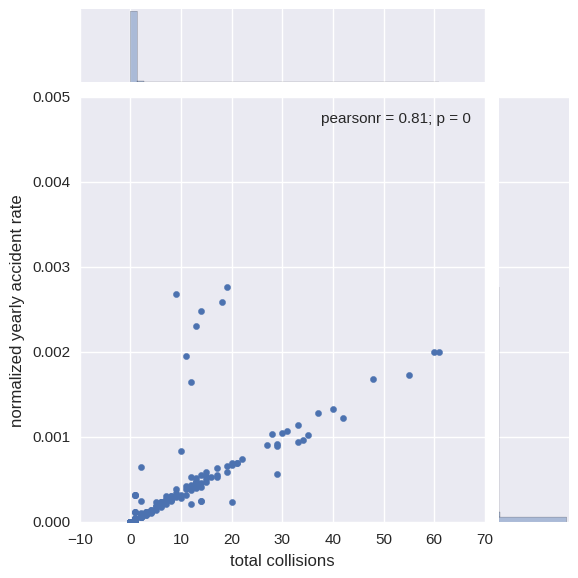

In [32]:
sns.set_context("notebook", font_scale=1.1)
scatter = sns.jointplot(x='total collisions', y = 'normalized yearly accident rate', data = df, ylim= (0,0.005))

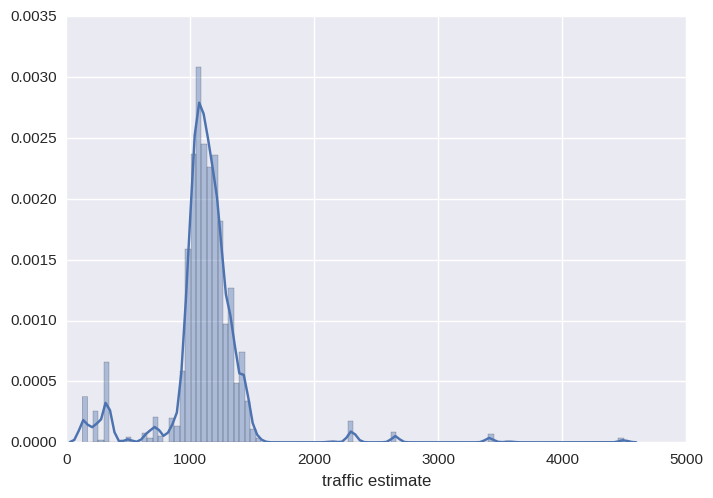

In [33]:
df.to_csv('totals_test.csv')
import scipy.stats as stats
sns.distplot(df["traffic estimate"], bins = 100)

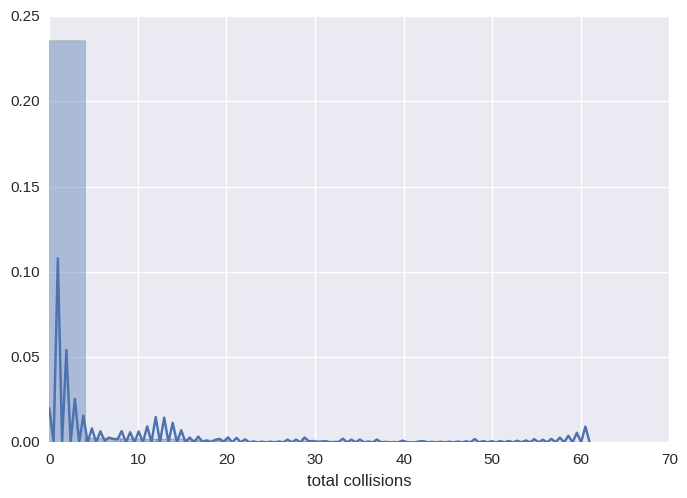

In [34]:
sns.distplot(df["total collisions"], bins = 15)

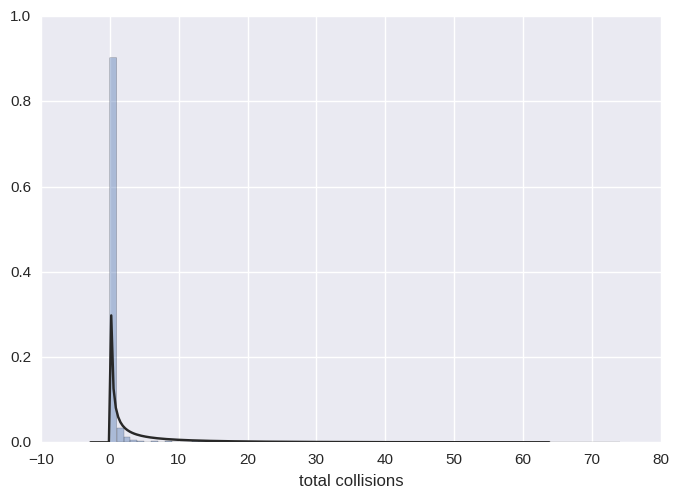

In [35]:
sns.distplot(df["total collisions"], fit=stats.gamma,  bins=range(0, 75, 1), kde=False)

A gamma distribution looks like a good choice. We know that we are dealing with sums of poission distributions where each intersection is basically a poisson process, with the mean accidents for a year being the parameter. So the above histogram is really summing up the number of accidents each year, over these poisson processes. While we could try and fit each intersection individually, this is a whole lot of work. And it's not clear how one would use these estimated parameters to compute the prior distribution for the ensemble. 

A gamma distribution looks nice, and intuitively makes sense since the prior for a poisson distribution is a gamma. Trying to read up on the intuition for how a ensemble of Poisson processes, each with their own paramater (not merely the same), has lead me to some very involved work on Bayesian inference for traffic problems, without directly diving into machine learning. We won't go that deep in this case though.

In [36]:
stats.gamma.fit(df['total collisions'], loc=0)

(0.068107731604731436, -1.816620331018423e-32, 17.521399606055539)

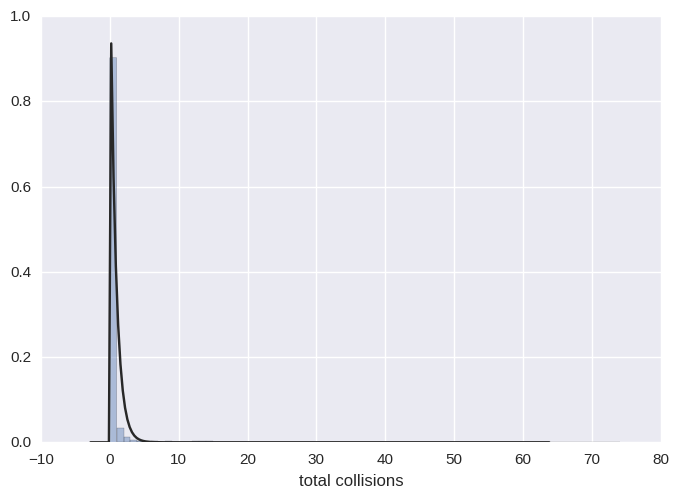

In [37]:
sns.distplot(df["total collisions"], fit=stats.expon,  bins=range(0, 75, 1), kde=False)

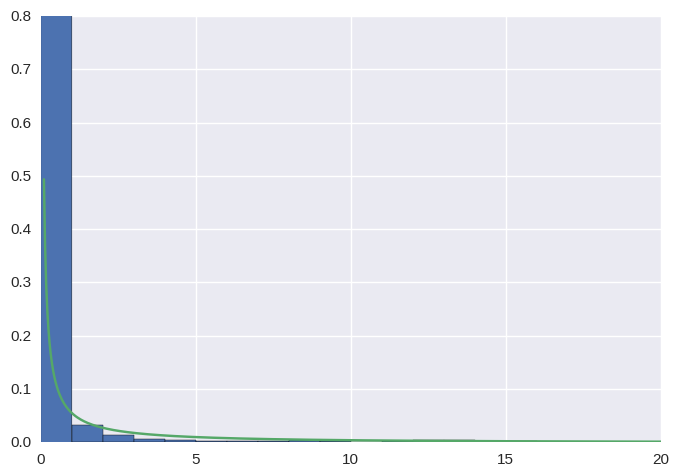

In [38]:
import matplotlib.pylab as plt

#plot normed histogram
plt.hist(df['total collisions'], normed=True,  bins=range(0, 75, 1))

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = 0.1, 75
lnspc = np.linspace(xmin, xmax, len(df))

# exactly same as above
ag,bg,cg = stats.gamma.fit(df['total collisions'], loc=0)  
pdf_gamma = stats.gamma.pdf(lnspc,ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

plt.axis([0,20,0,0.8])
plt.show()

Pretty good looking fit! Looks great.

In [40]:
beta = 1/cg
df['posterior mean'] = (ag + df['total collisions'])/(beta+24*df['traffic estimate']) 
df['posterior STD'] = np.sqrt((ag + df['total collisions'])/((beta+24*df['traffic estimate'])**2)) 

df.sort_values(by='posterior mean',ascending = False).head()

,normalized yearly accident rate,total collisions,traffic estimate,posterior mean,posterior STD
intersection,,,,,
"Bay St & Queens Quay W, Toronto, Ontario, M5J",0.002767,19.0,286.090314,0.002777,0.000636
"Queens Quay W & Rees St, Toronto, Ontario, M5J",0.002681,9.0,139.888889,0.002701,0.000897
"Queens Quay W & York St, Toronto, Ontario, M5J",0.002592,18.0,289.316788,0.002602,0.000612
"Lake Shore Blvd W & York St, Toronto, Ontario, M5J",0.002482,14.0,235.000000,0.002494,0.000665
"Lake Shore Blvd E & Yonge St, Toronto, Ontario, M5E",0.002305,13.0,235.000000,0.002317,0.000641
